# Statistical tests tutorial

This notebook will demonstrate how to use the `pyberries.stats` module to perform statistical tests on Bacmman measurements.

First, install PyBerries:

In [ ]:
%pip install PyBerries==0.2.18

## Import the data

Download and unzip the [example datasets](https://gitlab.com/MEKlab/pyberries/-/raw/main/Tutorial/Example_datasets.zip?inline=false).

Import the 4 datasets into a DatasetPool (remember to change the path according to the location of the `Example_datasets` folder on your computer):

In [1]:
path = 'C:\\Users\\dthedie\\Downloads\\Example_datasets'
dsList = ['Dataset1', 'Dataset2', 'Dataset3', 'Dataset4']

groups = ['No antibiotic', '+ antibiotic', 'No antibiotic', '+ antibiotic']

from pyberries.data import DatasetPool
data = DatasetPool(path=path, dsList=dsList, filters={}, groups=groups)

Dataset Dataset1: loaded objects ['Bacteria_large', 'Spot_detection']
Dataset Dataset2: loaded objects ['Bacteria_large', 'Spot_detection']
Dataset Dataset3: loaded objects ['Bacteria_large', 'Spot_detection']
Dataset Dataset4: loaded objects ['Bacteria_large', 'Spot_detection']


In this tutorial, we will explore the differences between cell length (`SpineLength` in `Bacteria_large`) and number of fluorescent spots (`SpotCount` in `Bacteria_large`) for the 4 datasets, spread in two groups.

Use `describe` to see the mean and standard deviation values:

In [2]:
data.describe(['mean', 'std'], object_name='Bacteria_large')

Bacteria_large


Group  nObjects  SpotCount (mean)  SpotCount (std)   
Dataset                                                                
Dataset1  No antibiotic     30865          0.151628         0.393966  \
Dataset2   + antibiotic     26786          0.562346         0.797429   
Dataset3  No antibiotic     32122          0.192703         0.457093   
Dataset4   + antibiotic     17228          0.383097         0.658480   

          SpineWidth (mean)  SpineWidth (std)  SpineLength (mean)   
Dataset                                                             
Dataset1           0.857611          0.104440            2.753508  \
Dataset2           0.915662          0.170566            4.471495   
Dataset3           0.852015          0.196708            2.867853   
Dataset4           0.873690          0.171769            3.686582   

          SpineLength (std)  
Dataset                      
Dataset1           0.995139  
Dataset2           2.781867  
Dataset3           1.354514  
Dataset4           2.151323

We can also visualise the average and standard deviation as a graph:

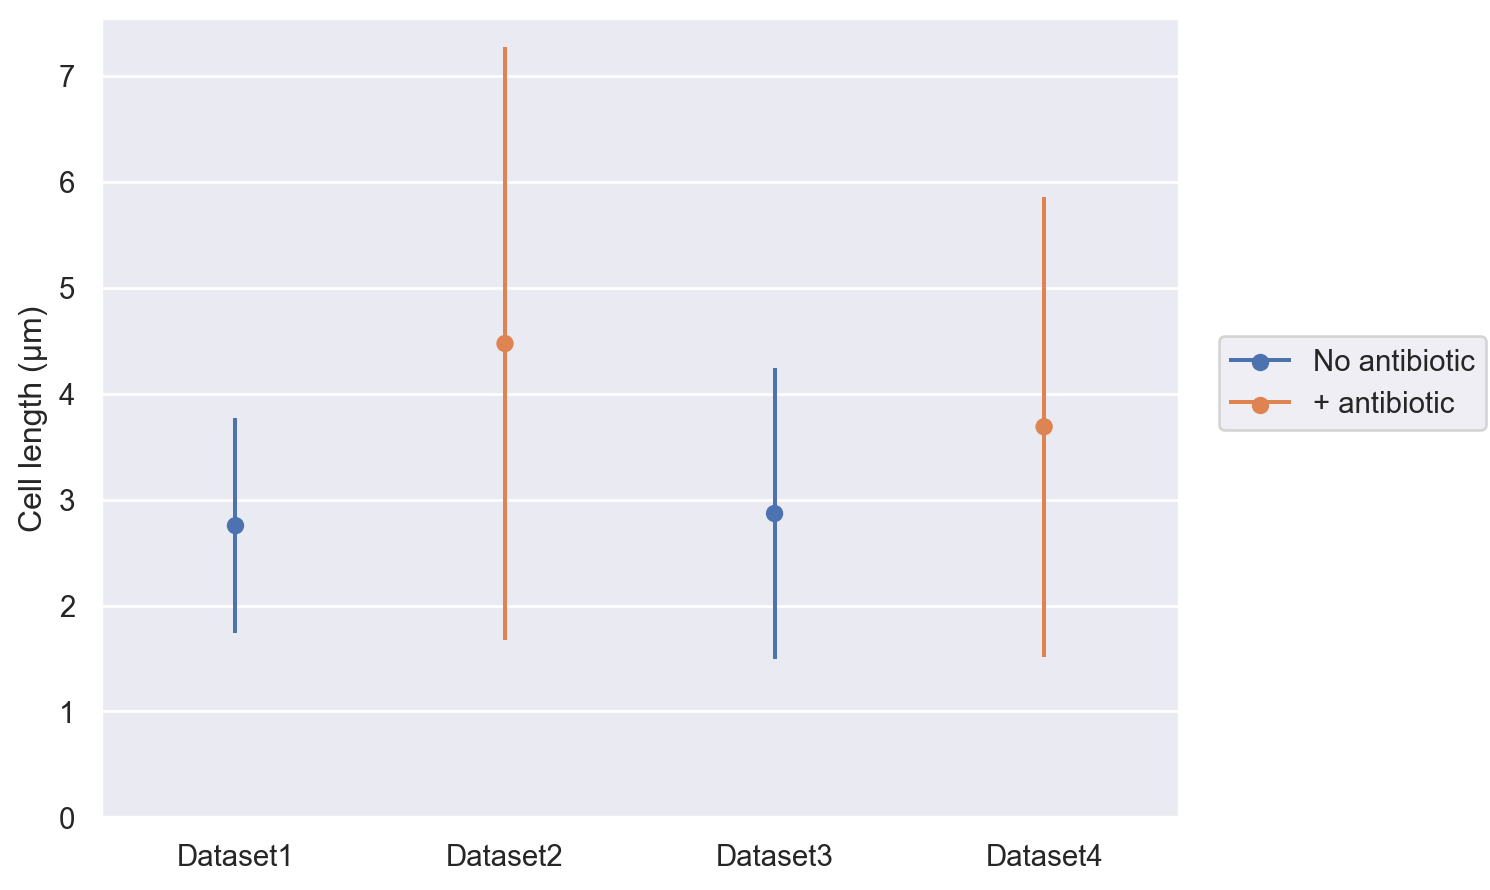

In [3]:
import seaborn.objects as so

(
    so.Plot(data.Bacteria_large, x='Dataset', y='SpineLength', color='Group')
    .add(so.Dot(), so.Est('mean'))
    .add(so.Range(), so.Est(errorbar='sd'))
    .scale(color='deep')
    .limit(x=(-0.5, 3.5), y=(0, None))
    .label(x="", y="Cell length (µm)", title='', color='')
)

## One-sided t-test

A one-sided t-test allows us to compare the mean value of a distribution (e.g. the mean cell length) to an arbitrary value.

To look at datasets individually we use the pandas method `.query` on `data.Bacteria_large`.

In [4]:
from pyberries.stats import ttest_1way

res = ttest_1way(data=data.Bacteria_large.query('Dataset == "Dataset1"'), col='SpineLength', test_mean=2)
print(res)

Effect size: 0.757189212346828
TtestResult(statistic=133.0263143486354, pvalue=0.0, df=30864)


Here, the extremely small p-value tells us that the average cell size distribution is significantly different from 2 um.

The fact that the difference is significant does not mean it is large. In fact, large sample sizes like ours (> 30,000 measurements) can often lead to very small differences being considered significant.

The `Effect size` gives us more information on how large the difference actually is. It is computed by the formula `(mean(distribution) - test_mean) / std(distribution)`

In this case, an effect size of 0.75 corresponds to a difference of 0.75 times the standard deviation.

## Two-sided t-test

A two-sided t-test allows to compare the means of two distributions.

Here, we can use it to compare the average cell length with and without antibiotic.

In [5]:
from pyberries.stats import ttest_2way

res_2way = ttest_2way(data=data.Bacteria_large, col='SpineLength', by='Group')
print(res_2way)

Effect size: 0.6742027093743801
Ttest_indResult(statistic=-115.03669632960684, pvalue=0.0)


Once again, the low p-value indicates a significant difference between the means of the two distributions.

The effect size (`(mean1 + mean2) / std`) tells us that the difference is ~0.67x the overall standard deviation.

## Tukey's test

Tukey's test allows us to test for differences between mean values for multiple groups.

Here, we look at differences between mean cell lengths for bacteria with different numbers of spots, with and without antibiotic.

First we can visualise the data (we only look at cells with up to 4 spots, since Tukey's test cannot deal with missing values):

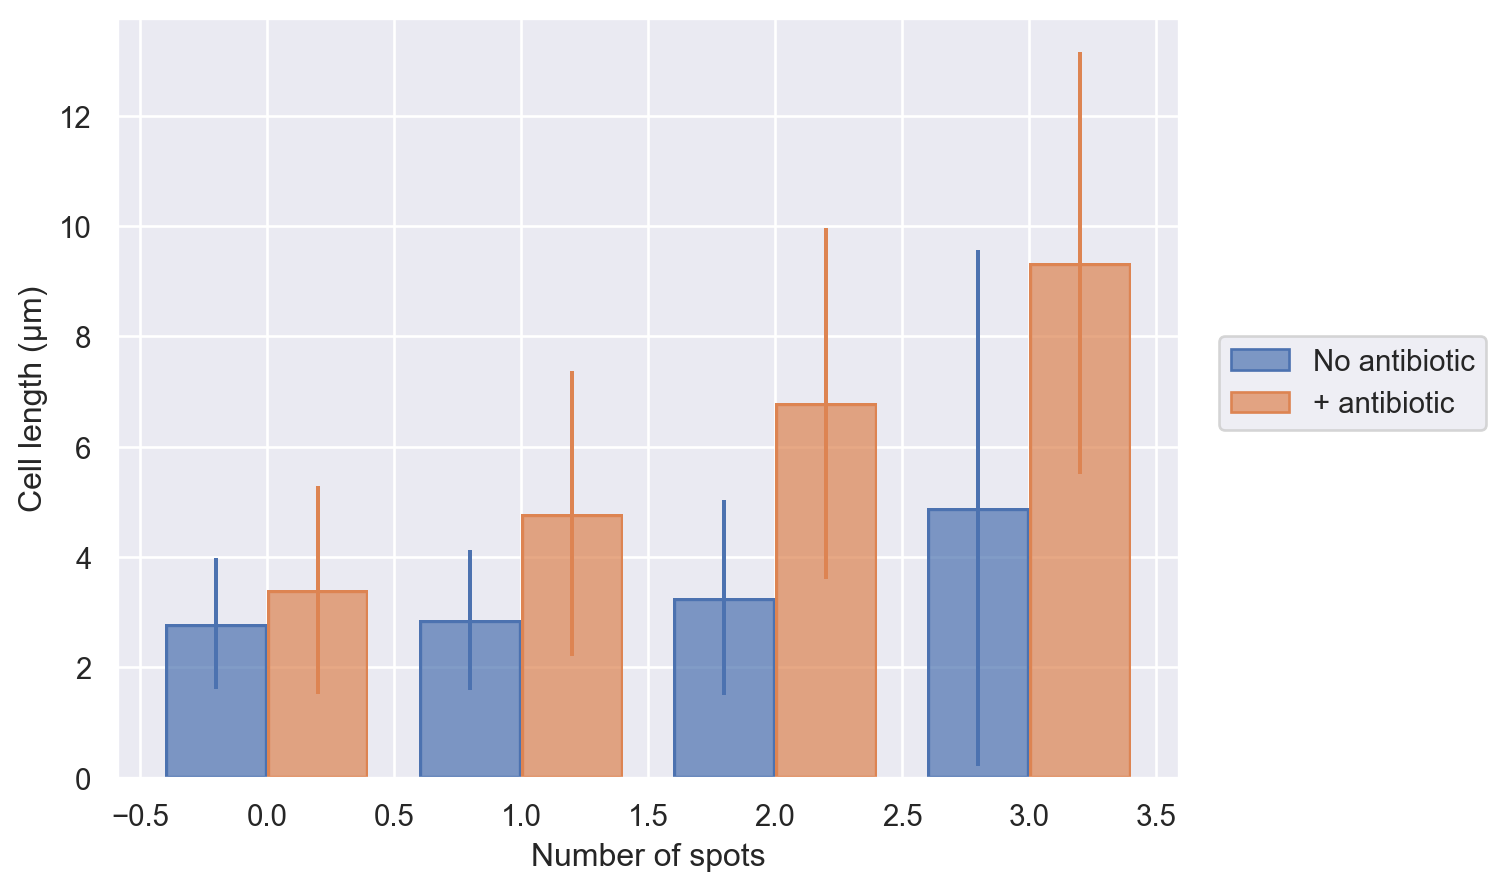

In [8]:
import seaborn.objects as so

(
    so.Plot(data.Bacteria_large.query('SpotCount < 4'), x='SpotCount', y='SpineLength', color='Group')
    .add(so.Bar(), so.Est('mean'), so.Dodge())
    .add(so.Range(), so.Est(errorbar='sd'), so.Dodge(), legend=False)
    .scale(color='deep')
    .limit(x=(None, None), y=(0, None))
    .label(x="Number of spots", y="Cell length (µm)", title='', color='')
)

Now we use the `tukey_test` function to evaluate pairwise distances between each of these datapoints.

In [9]:
from pyberries.stats import tukey_test

res = tukey_test(data=data.Bacteria_large.query('SpotCount < 4'), col='SpineLength', by=['SpotCount', 'Group'])
print(res)

Groups: ['0 No antibiotic' '1 No antibiotic' '2 No antibiotic' '3 No antibiotic'
 '0 + antibiotic' '1 + antibiotic' '2 + antibiotic' '3 + antibiotic']
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.068     0.011    -0.127    -0.009
 (0 - 2)     -0.470     0.000    -0.643    -0.298
 (0 - 3)     -2.097     0.000    -2.717    -1.477
 (0 - 4)     -0.605     0.000    -0.643    -0.567
 (0 - 5)     -1.994     0.000    -2.045    -1.943
 (0 - 6)     -3.993     0.000    -4.087    -3.899
 (0 - 7)     -6.529     0.000    -6.722    -6.336
 (1 - 0)      0.068     0.011     0.009     0.127
 (1 - 2)     -0.402     0.000    -0.582    -0.223
 (1 - 3)     -2.029     0.000    -2.651    -1.407
 (1 - 4)     -0.537     0.000    -0.600    -0.475
 (1 - 5)     -1.926     0.000    -1.997    -1.855
 (1 - 6)     -3.925     0.000    -4.032    -3.819
 (1 - 7)     -6.462     0.000    -6.661    -6.262
 (2 - 0)      0.470     0.000  

For each pairwise comparison, the `p-value` indicates the significance of the difference, while the `Statistic` tells us how large the difference is.

For example, using p < 0.05 as significance threshold, we can see:
- No antibiotic, 0 spot is not significantly different to No antibiotic, 1 spot (P = 0.011)
- No antibiotic, 0 spot is significantly different to No antibiotic, 2 spots (P < 0.001), with a difference of 0.47

## Displaying test results on graphs

From the `pyberries.plots` module, we can use the `Add_significance` function to display custom significance indicators. For example:

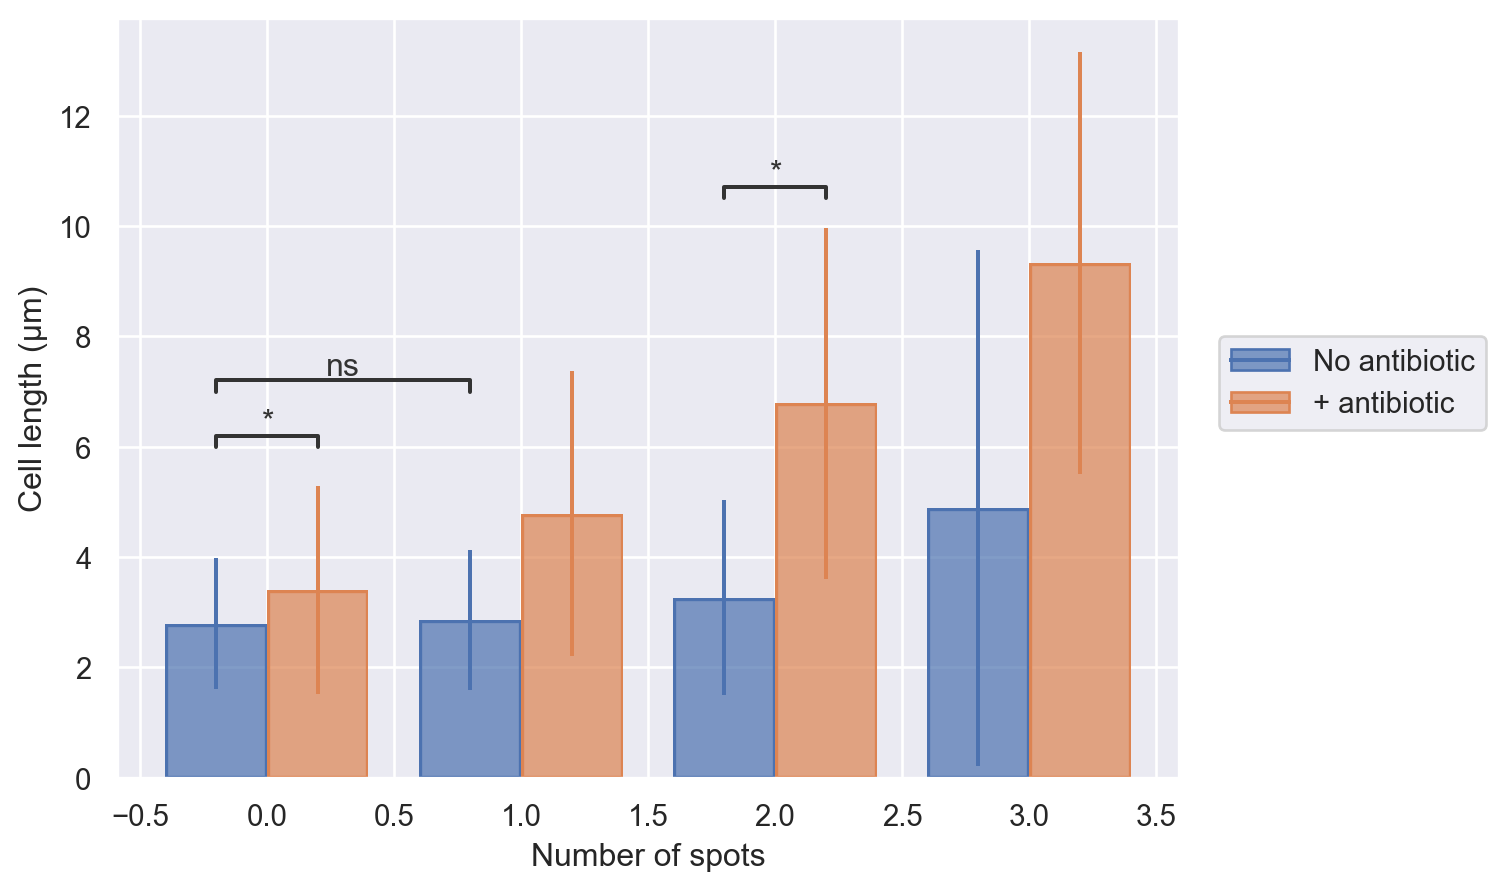

In [11]:
import seaborn.objects as so
from pyberries.plots import Add_significance

p = (
    so.Plot(data.Bacteria_large.query('SpotCount < 4'), x='SpotCount', y='SpineLength', color='Group')
    .add(so.Bar(), so.Est('mean'), so.Dodge())
    .add(so.Range(), so.Est(errorbar='sd'), so.Dodge(), legend=False)
    .scale(color='deep')
    .limit(x=(None, None), y=(0, None))
    .label(x="Number of spots", y="Cell length (µm)", title='', color='')
)

p = Add_significance(p, x1=-0.2, x2=0.8, y=7, h=0.2, text='ns')
p = Add_significance(p, x1=-0.2, x2=0.2, y=6, h=0.2, text='*')
Add_significance(p, x1=1.8, x2=2.2, y=10.5, h=0.2, text='*')